In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer('all-mpnet-base-v2')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils  import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [2]:
fc_df = pd.read_csv('fc_df2.csv', encoding='utf-8', index_col = 0, low_memory = False)

In [3]:
fc_df.head()

,post,author,status,date_num,post_ai_response
5403,"""In 2008 (Mandel) was re-elected to a second t...",Josh Mandel,mostly-true,3883,"In 2008, Democrat Tim Mandel was re-elected to..."
14207,A Centers for Disease Control and Prevention c...,Viral image,false,7784,The Centers for Disease Control and Prevention...
3197,Says Florida officials amended a contract from...,Richard Corcoran,mostly-true,6285,Florida officials have amended a contract with...
8281,"Says Ellen Rosenblum ""has said over and over a...",Dwight Holton,half-true,4477,Ellen Rosenblum is the Attorney General of Ore...
4617,Says the Central Health district's tax rate is...,Keep Austin Healthy PAC,mostly-true,4674,The Central Health district in Texas has the l...


## Exploratory analysis

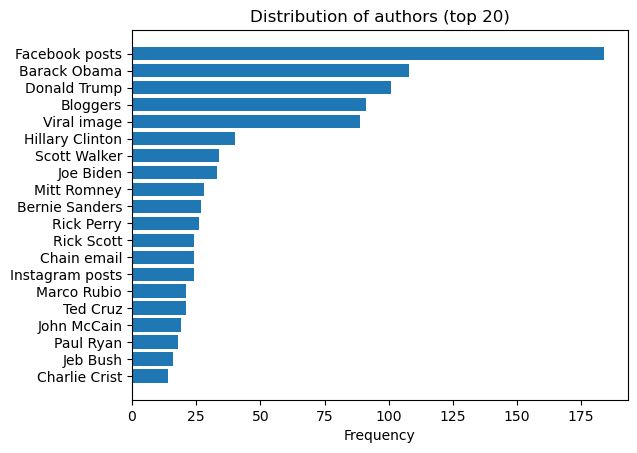

In [4]:
df_plot1 = fc_df.author.value_counts(ascending=False).head(20)

plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(df_plot1.index))

ax.barh(y_pos, df_plot1, align='center')
ax.set_yticks(y_pos, labels=df_plot1.index)
ax.invert_yaxis()
ax.set_xlabel('Frequency')
ax.set_title('Distribution of authors (top 20)')

plt.savefig('Authors.png', dpi=300, bbox_inches='tight')

plt.show()

Right away from this plot we can pick up some insights:
1. The absolute leader in suspicious posts is Facebook.
2. The second place is shared between Presidents (Obama and Trump), collective bloggers and viral images. Biden is not in the group because he became the President of US only in the January 2021 and our data cut is up to September 2021.
3. And others are notable politicians like (Hillary Clinton, Bernie Sanders, John McCain) with exeptions of Instagram posts and Chain emails.

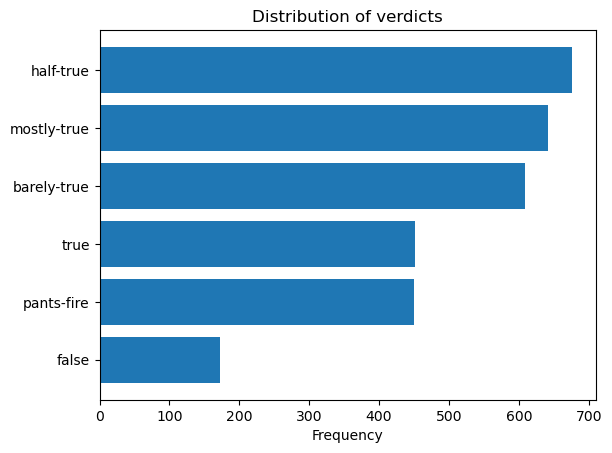

In [5]:
df_plot2 = fc_df.status.value_counts()

plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(df_plot2.index))

ax.barh(y_pos, df_plot2, align='center')
ax.set_yticks(y_pos, labels=df_plot2.index)
ax.invert_yaxis()
ax.set_xlabel('Frequency')
ax.set_title('Distribution of verdicts')

plt.savefig('Verdicts.png', dpi=300, bbox_inches='tight')

plt.show()

We can see that that we have more or less uniform distribution. With exceptions of "false" claims. Potential reason is the difference in definition of "false" and "pants on fire" claims. The difference between them is that "pants on fire" claim is ridiculous. So our assumption is that if subject is already lying, then maybe it makes sense to "stretch" the claim to the max, because people tend to believe it more that way. But that is just our assumption and it is out of scope of this research.

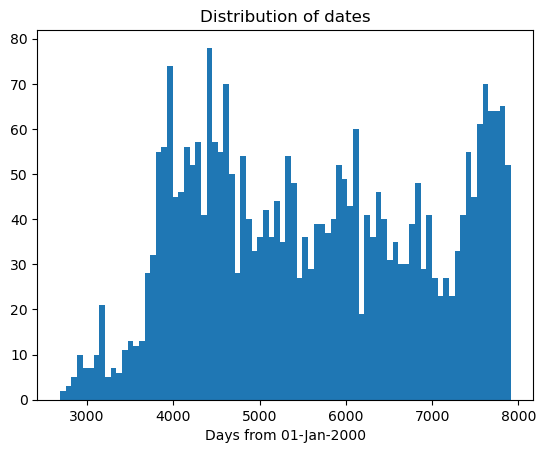

In [6]:
df_plot3 = fc_df.date_num

plt.rcdefaults()
fig, ax = plt.subplots()

plt.hist(fc_df.date_num, bins=80)

ax.set_xlabel('Days from 01-Jan-2000')
ax.set_title('Distribution of dates')

plt.savefig('Dates.png', dpi=300, bbox_inches='tight')

plt.show()

To get some insights it makes sense to split this graph roughly in 2 parts: run-up (somewhere before day 4000) stable (after running-up to nowadays). Since website Politifact.com started its work only from 2007, it took them some time to collect claims and investigators who have checked these claims. That's why we can see this slow initial increase in amount of claim during running-up period. Next, during stable period we can't see any stable trends, but rather we can separate 3 peaks around day 4500, 6000, 7500, which roughly matches with USA president election campaign in 2012, 2016 and 2020. This correlation supports our initial assumption about connection between time and misinformation, specifically that amount of misinformation connected primarily to political agenda, if we are talking timewise. Although, worth to mention, we are not stating nor going to assess causality relationship in this research between these two variables.

## Main Analysis

In the end we want to compare confusion matrix and accuracy of 8 different models:
1. Original post vectorized by TF-IDF + metadata using SVM
2. Original post vectorized by TF-IDF + metadata uning Artificial Neural Network (ANN)
3. Original post vectorized by pretrained exteranal model + metadata using SVM
4. Original post vectorized by pretrained exteranal model + metadata uning ANN
5. AI response vectorized by TF-IDF + metadata using SVM
6. AI response vectorized by TF-IDF + metadata uning Artificial Neural Network (ANN)
7. AI response vectorized by pretrained exteranal model + metadata using SVM
8. AI response vectorized by pretrained exteranal model + metadata using ANN

### Splitting the data

In [7]:
df_train, df_test = train_test_split(fc_df, test_size = 0.1)

### Separating features from label

In [8]:
x_train = df_train.drop('status',axis = 1)
y_train = df_train['status']

x_test = df_test.drop('status',axis = 1)
y_test = df_test['status']

### Encoding "author"

Before fitting the data into the model we need to convert categorical "author" variable to some numerical values, in this approach we will try to convert it using OneHotEncoder.

In [9]:
# Separating "author" variable from other
x_train_cat = x_train['author'].to_frame()
x_test_cat = x_test['author'].to_frame()

x_train_oth = x_train.drop('author',axis = 1)
x_test_oth = x_test.drop('author',axis = 1)

# Building encoding model
enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
enc.fit(x_train_cat)

# Encoding "author" variable and converting encoded vector back to df
x_train_cat_arr = enc.transform(x_train_cat)
x_test_cat_arr = enc.transform(x_test_cat)

x_train_cat = pd.DataFrame(x_train_cat_arr, columns=enc.get_feature_names_out(), index = x_train_cat.index)
x_test_cat = pd.DataFrame(x_test_cat_arr, columns=enc.get_feature_names_out(), index = x_test_cat.index)

# Concating them back together
x_train = pd.concat([x_train_oth, x_train_cat], axis = 1)
x_test = pd.concat([x_test_oth, x_test_cat], axis = 1)

### Label encoder

ANN requires specific format for label, that's why we need to pass it through "to_categorical" function.

In [10]:
le = LabelEncoder()
le.fit(["true","mostly-true","half-true","barely-true","false","pants-fire"])

def LE(y_train,y_test,ANN = False):
    
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)

    if ANN == True:
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
        
    return y_train, y_test

### TF-IDF Vectorizer function

In [11]:
def TF_IDF_Vec(x_train, x_test, var):
    
    def preprocessing(text):
        """
        TFIDF requires "clean" text as input
        """
        text = text.lower() 
        tokenizer = RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(text)
        meaningful_words = [word for word in words if word not in stop_words]
        stemmer = PorterStemmer()
        stemmed_words = [stemmer.stem(word) for word in meaningful_words]
        return " ".join(stemmed_words)
    
    #Creating corpus
    corpus_train = x_train[var].apply(preprocessing)
    corpus_test = x_test[var].apply(preprocessing)

    #Creating vectorizer and training it + receiving TF-IDF score matrix for train and test dataframe
    vectorizer = TfidfVectorizer()
    
    train_term_matrix = vectorizer.fit_transform(corpus_train)
    test_term_matrix = vectorizer.transform(corpus_test)

    #converting matrix to dataframe 
    tfidf_df_train = pd.DataFrame(train_term_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    tfidf_df_test = pd.DataFrame(test_term_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    
    #since we had encoded our original text, wo don't need it anymore  
    x_train = x_train.drop(["post", "post_ai_response"],axis = 1)
    x_test = x_test.drop(["post", "post_ai_response"],axis = 1)
    
    #creating final dataframe
    x_train = pd.concat([x_train.reset_index(drop=True), tfidf_df_train], axis=1)
    x_test = pd.concat([x_test.reset_index(drop=True), tfidf_df_test], axis=1)
    
    return x_train, x_test

### Semantic vectorizer function

In [12]:
def Semantic_Vec(x_train, x_test, var):

    def Vectorizer(text):
        """
        this function:
        1. splits the text into sentences
        2. creates semantic vector for each sentence
        3. takes the mean of them
        """
        sentences = sent_tokenize(text)

        vectors = []
        for sentence in sentences:
            vector = sentence_model.encode(sentence)
            vectors.append(vector)

        array = np.mean(np.array(vectors), axis = 0)

        return pd.Series(array)

    #creating semantic vector
    x_train_sem = x_train[var].progress_apply(Vectorizer)
    x_test_sem = x_test[var].progress_apply(Vectorizer)
    
    #adding specific prefix to distinguish these variables
    x_train_sem = x_train_sem.add_prefix('sem_')
    x_test_sem = x_test_sem.add_prefix('sem_')
    
    #since we had encoded our original text, wo don't need it anymore  
    x_train = x_train.drop(["post", "post_ai_response"],axis = 1)
    x_test = x_test.drop(["post", "post_ai_response"],axis = 1)
    
    #adding semantic vector back to the main dataframe 
    x_train = pd.concat([x_train,x_train_sem], axis = 1)
    x_test = pd.concat([x_test,x_test_sem], axis = 1)
    
    return x_train, x_test

### Creating full set of features

In [13]:
# Dataframes for:
# - Original post vectorized by TF-IDF + metadata using SVM
# - Original post vectorized by TF-IDF + metadata uning ANN
x_train1, x_test1 = TF_IDF_Vec(x_train, x_test, var = 'post')

# Dataframes for:
# - Original post vectorized by pretrained exteranal model + metadata using SVM
# - Original post vectorized by pretrained exteranal model + metadata uning ANN
x_train2, x_test2 = Semantic_Vec(x_train, x_test, var = 'post')

# Dataframes for:
# - AI response vectorized by TF-IDF + metadata using SVM
# - AI response vectorized by TF-IDF + metadata uning ANN
x_train3, x_test3 = TF_IDF_Vec(x_train, x_test, var = 'post_ai_response')

# Dataframes for:
# - AI response vectorized by pretrained exteranal model + metadata using SVM
# - AI response vectorized by pretrained exteranal model + metadata uning ANN
x_train4, x_test4 = Semantic_Vec(x_train, x_test, var = 'post_ai_response')

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

### Function to postprocess features to make them "model-ready"

Since we have a lot of features created during vectorizing process, it makes sense to reduce total amount of them using PCA, when we are working with SVM.

In [14]:
def Feature_Postprocessing(x_train, x_test, ANN = False):
    
    #Standartization step
    scaler = StandardScaler(with_mean = False)
    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    if ANN == False:

        ## Dimentionality reduction
        pca = PCA(n_components = 100)
        pca.fit(x_train)

        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)
    
    return x_train, x_test


### Creating "Model-ready" labels

In [15]:
# labels for SVM
y_train_SVM, y_test_SVM = LE(y_train, y_test, ANN = False)

# Labels for ANN
y_train_ANN, y_test_ANN = LE(y_train, y_test, ANN = True)

### Creating "Model-ready" features

In [16]:
# Dataframes for:

# - Original post vectorized by TF-IDF + metadata using SVM
x_train1_SVM, x_test1_SVM = Feature_Postprocessing(x_train1, x_test1, ANN = False)

# - Original post vectorized by TF-IDF + metadata uning ANN
x_train1_ANN, x_test1_ANN = Feature_Postprocessing(x_train1, x_test1, ANN = True)

# - Original post vectorized by pretrained exteranal model + metadata using SVM
x_train2_SVM, x_test2_SVM = Feature_Postprocessing(x_train2, x_test2, ANN = False)

# - Original post vectorized by pretrained exteranal model + metadata uning ANN
x_train2_ANN, x_test2_ANN = Feature_Postprocessing(x_train2, x_test2, ANN = True)

# - Original post vectorized by TF-IDF + metadata using SVM
x_train3_SVM, x_test3_SVM = Feature_Postprocessing(x_train3, x_test3, ANN = False)

# - Original post vectorized by TF-IDF + metadata uning ANN
x_train3_ANN, x_test3_ANN = Feature_Postprocessing(x_train3, x_test3, ANN = True)

# - Original post vectorized by pretrained exteranal model + metadata using SVM
x_train4_SVM, x_test4_SVM = Feature_Postprocessing(x_train4, x_test4, ANN = False)

# - Original post vectorized by pretrained exteranal model + metadata uning ANN
x_train4_ANN, x_test4_ANN = Feature_Postprocessing(x_train4, x_test4, ANN = True)

### Hyperparameter tuning

Hyperparameter tuning for SVM was done with a help of GridSearch.

Hyperparameter tuning for ANN was done manually by sequentual change of different hyperparamters, untill model performance on validation set couldn't be improved anymore.

### Building SVM model

In [17]:
def SVM_model(x_train, x_test, y_train, y_test, label, figname):
    
    model = SVC(C = 1, kernel = 'rbf')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    acc_score = accuracy_score(y_test,y_pred)
    
    # Compute the confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize = 'true'),columns = le.classes_, index = le.classes_)
    
    # Reordering label categories, to spot any trend
    cm = cm[["false", "pants-fire", "barely-true", "half-true", "mostly-true", "true"]]
    cm = cm.reindex(["false", "pants-fire", "barely-true", "half-true", "mostly-true", "true"])

    # Plot the confusion matrix.
    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax = sns.heatmap(cm, annot = True, fmt=".1%", cmap="crest", cbar = False)

    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.suptitle(label,fontsize=17)
    plt.title('Confusion Matrix',fontsize=13)
        
    plt.savefig(figname + '.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print('Accuracy: {:.3f}'.format(acc_score))

    return model

### Building ANN model

In [18]:
def ANN_model(x_train, x_test, y_train, y_test, label, figname):
    
    n_vars = x_train.shape[1]
    nodes = 1500
    activ = 'relu'
    opt = Adam(learning_rate=0.0001)
    
    model = Sequential()
    model.add(Dense(nodes, activation = activ, input_shape = (n_vars,)))
    model.add(Dense(nodes, activation = activ))
    model.add(Dense(nodes, activation = activ))
    model.add(Dense(nodes, activation = activ))
    model.add(Dense(6,   activation = 'softmax'))
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=3)
    
    model.fit(x_train, y_train
            , epochs = 10
            , verbose = 0
            , validation_split = 0.2
            , callbacks = [monitor_val_acc])
    
    accuracy = model.evaluate(x_test, y_test, verbose = 0)
    
    # Compute the confusion matrix
    y_pred = np.argmax(model.predict(x_test, verbose = 0),axis = 1)
    y_test = np.argmax(y_test,axis = 1)
    
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize = 'true'),columns = le.classes_, index = le.classes_)
    
    # Changing order for labels to spot any ordinal relationship between the labels 
    cm = cm[["false", "pants-fire", "barely-true", "half-true", "mostly-true", "true"]]
    cm = cm.reindex(["false", "pants-fire", "barely-true", "half-true", "mostly-true", "true"])

    # Plot the confusion matrix.
    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax = sns.heatmap(cm, annot = True, fmt=".1%", cmap="crest", cbar = False)

    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.suptitle(label,fontsize=17)
    plt.title('Confusion Matrix',fontsize=13)
    
    plt.savefig(figname + '.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print('Accuracy: {:.3f}'.format(accuracy[1]))
    
    return model

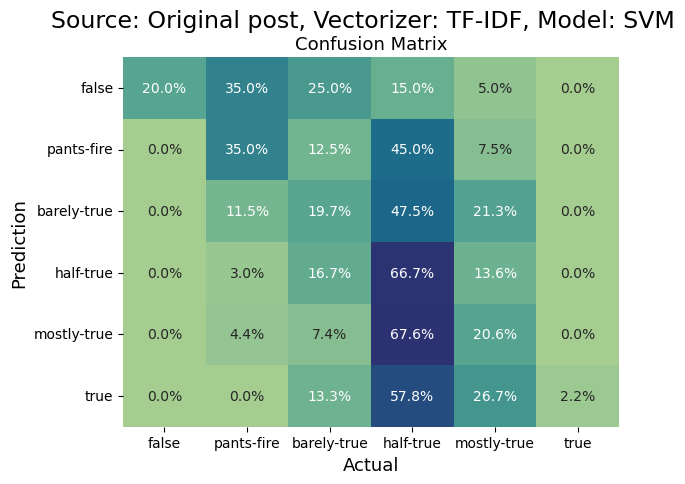

Accuracy: 0.297


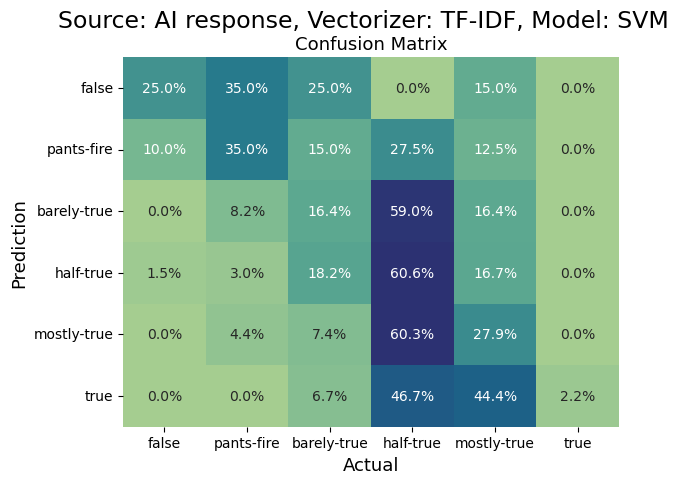

Accuracy: 0.297


In [19]:
model1 = SVM_model(x_train1_SVM, x_test1_SVM, y_train_SVM, y_test_SVM, label = 'Source: Original post, Vectorizer: TF-IDF, Model: SVM', figname = 'Orig_TF_SVM')
model5 = SVM_model(x_train3_SVM, x_test3_SVM, y_train_SVM, y_test_SVM, label = 'Source: AI response, Vectorizer: TF-IDF, Model: SVM', figname = 'AI_TF_SVM')

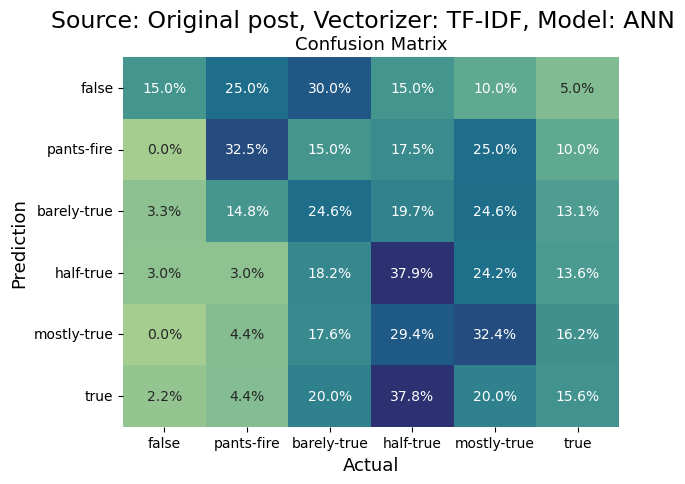

Accuracy: 0.283


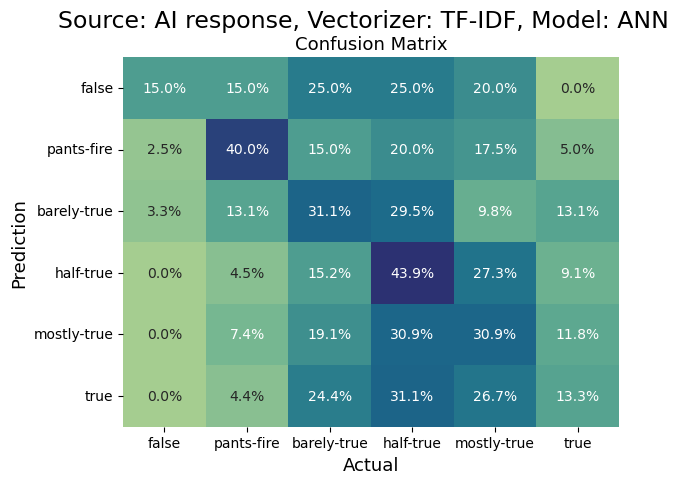

Accuracy: 0.313


In [20]:
model2 = ANN_model(x_train1_ANN, x_test1_ANN, y_train_ANN, y_test_ANN, label = 'Source: Original post, Vectorizer: TF-IDF, Model: ANN', figname = 'Orig_TF_ANN')
model6 = ANN_model(x_train3_ANN, x_test3_ANN, y_train_ANN, y_test_ANN, label = 'Source: AI response, Vectorizer: TF-IDF, Model: ANN', figname = 'AI_TF_ANN')

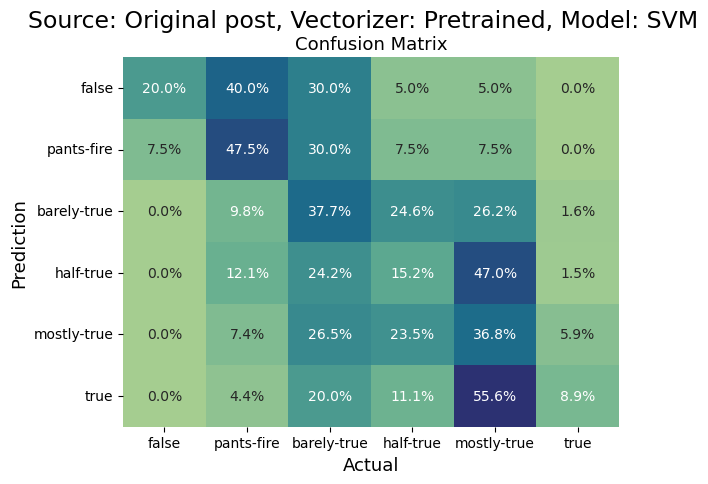

Accuracy: 0.283


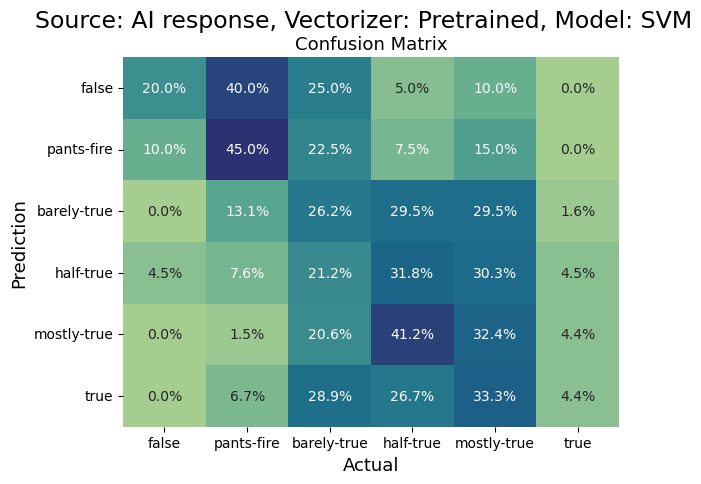

Accuracy: 0.277


In [21]:
model3 = SVM_model(x_train2_SVM, x_test2_SVM, y_train_SVM, y_test_SVM, label = 'Source: Original post, Vectorizer: Pretrained, Model: SVM', figname = 'Orig_PT_SVM')
model7 = SVM_model(x_train4_SVM, x_test4_SVM, y_train_SVM, y_test_SVM, label = 'Source: AI response, Vectorizer: Pretrained, Model: SVM', figname = 'AI_PT_SVM')

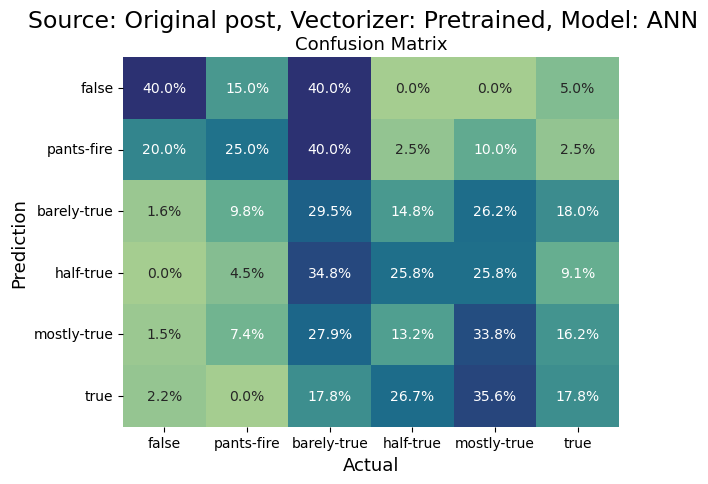

Accuracy: 0.280


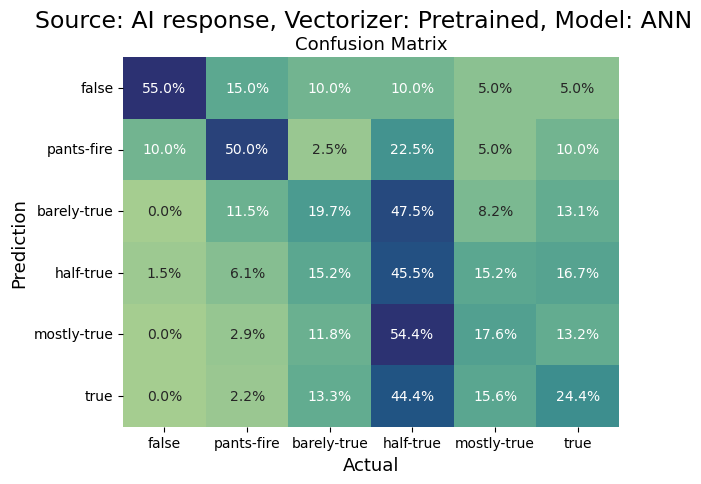

Accuracy: 0.320


In [22]:
model4 = ANN_model(x_train2_ANN, x_test2_ANN, y_train_ANN, y_test_ANN, label = 'Source: Original post, Vectorizer: Pretrained, Model: ANN', figname = 'Orig_PT_ANN')
model8 = ANN_model(x_train4_ANN, x_test4_ANN, y_train_ANN, y_test_ANN, label = 'Source: AI response, Vectorizer: Pretrained, Model: ANN', figname = 'AI_PT_ANN')

### Discussions and conslusions

Discussions and conclusions are mentioned in the research paper.